In [1]:
import ogr
import json
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [2]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [3]:
train = pd.read_csv("data/train_without_noise.csv", parse_dates=["timestamp"])
test = pd.read_csv("data/test.csv", parse_dates=["timestamp"])

### Feature Engineering

In [4]:
# moscow additional data
driver = ogr.GetDriverByName("ESRI Shapefile")
shp = driver.Open("data/administrative-divisions-of-moscow/moscow_adm.shp")
layer = shp.GetLayer()

In [5]:
# coordinates have different sizes in list
shape_json = json.loads(layer.GetFeature(0).ExportToJson())
len_list = len(np.array(shape_json["geometry"]["coordinates"]).shape)

shape_json1 = json.loads(layer.GetFeature(1).ExportToJson())
len_list1 = len(np.array(shape_json1["geometry"]["coordinates"]).shape)
len_list, len_list1

(2, 3)

In [6]:
# sub_area
okrug = []
sub_area = []
coordinates = []
for i in range(layer.GetFeatureCount()):
    sub_area.append(layer.GetFeature(i).GetField("RAION"))
    okrug.append(layer.GetFeature(i).GetField("OKRUGS"))
    shape_json = json.loads(layer.GetFeature(i).ExportToJson())
    if len(np.array(shape_json["geometry"]["coordinates"]).shape) == 2:
        coordinates.append(np.mean(np.array(shape_json["geometry"]["coordinates"][0][0]), axis=0))
    else:
        coordinates.append(np.mean(np.array(shape_json["geometry"]["coordinates"][0]), axis=0))

##### Train

In [7]:
# timestamp
"""
train["year"] = train.timestamp.apply(lambda x: x.year)
train["month"] = train.timestamp.apply(lambda x: x.month)
train["day"] = train.timestamp.apply(lambda x: x.day)
train["week"] = train.timestamp.apply(lambda x: x.week)
train["week_day"] = train.timestamp.apply(lambda x: x.dayofweek)
"""
# to-do add season for housing prices

'\ntrain["year"] = train.timestamp.apply(lambda x: x.year)\ntrain["month"] = train.timestamp.apply(lambda x: x.month)\ntrain["day"] = train.timestamp.apply(lambda x: x.day)\ntrain["week"] = train.timestamp.apply(lambda x: x.week)\ntrain["week_day"] = train.timestamp.apply(lambda x: x.dayofweek)\n'

In [8]:
# house
train["diff_max_floor"] = train.max_floor - train.floor
train["perc_max_floor"] = train.floor / train.max_floor
train["diff_full_life_sq"] = train.full_sq - train.life_sq
train["perc_full_life_sq"] = train.life_sq / train.full_sq
train["diff_full_kitch_sq"] = train.full_sq - train.kitch_sq
train["perc_full_kitch_sq"] = train.kitch_sq / train.full_sq
train["diff_full_life_kitch_sq"] = train.full_sq - train.life_sq - train.kitch_sq
train["perc_full_extra_sq"] = (train.life_sq + train.kitch_sq) / train.full_sq
train["sum_life_kitch"] = train.life_sq + train.kitch_sq
train["roomsize"] = (train.life_sq - train.kitch_sq) / train.num_room
train["age_at_sale"] = (train.timestamp.apply(lambda x: x.year) - train.build_year).apply(lambda x: x if x < 1500 else None)

In [9]:
# school 
train["perc_preschool"] = train.children_preschool / train.preschool_quota
train["perc_school"] = train.children_school / train.school_quota

In [10]:
# sub-area

kremlin = (37.617499, 55.752023) # long / # lat
moscow_uni = (37.528798, 55.704098)

moscow_df = pd.DataFrame({"sub_area": sub_area, "okrug": okrug, "coordinates": coordinates})
moscow_df["distance_from_kremlin"] = moscow_df.coordinates.apply(lambda x: haversine(x[0], x[1], kremlin[0], kremlin[1]))
moscow_df["distance_from_moscow_uni"] = moscow_df.coordinates.apply(lambda x: haversine(x[0], x[1], moscow_uni[0], moscow_uni[1]))
                                                                                        
moscow_df.drop("coordinates", axis=1, inplace=True)
train = pd.merge(train, moscow_df, how="left", on="sub_area")

# to-do maybe add distance to financial district

In [11]:
# reset index
train.set_index("id", inplace=True)

##### Test

In [12]:
# timestamp
"""
test["year"] = test.timestamp.apply(lambda x: x.year)
test["month"] = test.timestamp.apply(lambda x: x.month)
test["day"] = test.timestamp.apply(lambda x: x.day)
test["week"] = test.timestamp.apply(lambda x: x.week)
test["week_day"] = test.timestamp.apply(lambda x: x.dayofweek)
"""

'\ntest["year"] = test.timestamp.apply(lambda x: x.year)\ntest["month"] = test.timestamp.apply(lambda x: x.month)\ntest["day"] = test.timestamp.apply(lambda x: x.day)\ntest["week"] = test.timestamp.apply(lambda x: x.week)\ntest["week_day"] = test.timestamp.apply(lambda x: x.dayofweek)\n'

In [13]:
# house
test["diff_max_floor"] = test.max_floor - test.floor
test["perc_max_floor"] = test.floor / test.max_floor
test["diff_full_life_sq"] = test.full_sq - test.life_sq
test["perc_full_life_sq"] = test.life_sq / test.full_sq
test["diff_full_kitch_sq"] = test.full_sq - test.kitch_sq
test["perc_full_kitch_sq"] = test.kitch_sq / test.full_sq
test["diff_full_life_kitch_sq"] = test.full_sq - test.life_sq - test.kitch_sq
test["perc_full_extra_sq"] = (test.life_sq + test.kitch_sq) / test.full_sq
test["sum_life_kitch"] = test.life_sq + test.kitch_sq
test["roomsize"] = (test.life_sq - test.kitch_sq) / test.num_room
test["age_at_sale"] = (test.timestamp.apply(lambda x: x.year) - test.build_year).apply(lambda x: x if x < 1500 else None)

In [14]:
# school 
test["perc_preschool"] = test.children_preschool / test.preschool_quota
test["perc_school"] = test.children_school / test.school_quota

In [15]:
# sub-area

kremlin = (37.617499, 55.752023) # long / # lat
moscow_uni = (37.528798, 55.704098)

moscow_df = pd.DataFrame({"sub_area": sub_area, "okrug": okrug, "coordinates": coordinates})
moscow_df["distance_from_kremlin"] = moscow_df.coordinates.apply(lambda x: haversine(x[0], x[1], kremlin[0], kremlin[1]))
moscow_df["distance_from_moscow_uni"] = moscow_df.coordinates.apply(lambda x: haversine(x[0], x[1], moscow_uni[0], moscow_uni[1]))
                                                                                        
moscow_df.drop("coordinates", axis=1, inplace=True)
test = pd.merge(test, moscow_df, how="left", on="sub_area")

# to-do maybe add distance to financial district

In [16]:
# reset index
test.set_index("id", inplace=True)

### Transformation

In [17]:
y_train = train["price_doc"]
x_train = train.drop(["timestamp", "price_doc"], axis=1)

In [18]:
# transform non-numerical variables
for c in x_train.columns:
    if x_train[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))

In [19]:
# replace missing values with mean values
"""
for c in x_train.columns:
    x_train[c].fillna(x_train[c].mean(), inplace=True)
"""

'\nfor c in x_train.columns:\n    x_train[c].fillna(x_train[c].mean(), inplace=True)\n'

In [20]:
x_test = test.drop(["timestamp"], axis=1)

In [21]:
# transform non-numerical variables
for c in x_test.columns:
    if x_test[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))

In [22]:
# replace missing values with mean values
"""
for c in x_test.columns:
    x_test[c].fillna(x_test[c].mean(), inplace=True)
"""

'\nfor c in x_test.columns:\n    x_test[c].fillna(x_test[c].mean(), inplace=True)\n'

In [23]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "objective": "reg:linear",
    "eval_metric": "rmse",
    "silent": 1,
    "seed":42
}

In [24]:
dtrain = xgb.DMatrix(x_train, y_train)

In [25]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:8.12198e+06	test-rmse:8.12919e+06
[50]	train-rmse:2.49332e+06	test-rmse:2.89306e+06
[100]	train-rmse:2.17841e+06	test-rmse:2.72201e+06
[150]	train-rmse:2.0638e+06	test-rmse:2.6852e+06
[200]	train-rmse:1.98429e+06	test-rmse:2.66909e+06
[250]	train-rmse:1.91302e+06	test-rmse:2.65606e+06
[300]	train-rmse:1.84927e+06	test-rmse:2.65116e+06
[350]	train-rmse:1.79188e+06	test-rmse:2.645e+06
[400]	train-rmse:1.73789e+06	test-rmse:2.64353e+06
[450]	train-rmse:1.68854e+06	test-rmse:2.64176e+06
[500]	train-rmse:1.64378e+06	test-rmse:2.64068e+06


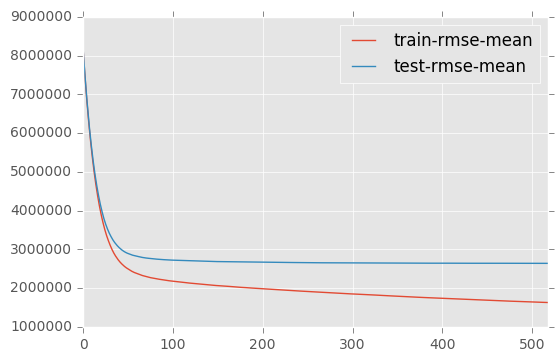

In [26]:
cv_output[["train-rmse-mean", "test-rmse-mean"]].plot()
pass

In [27]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

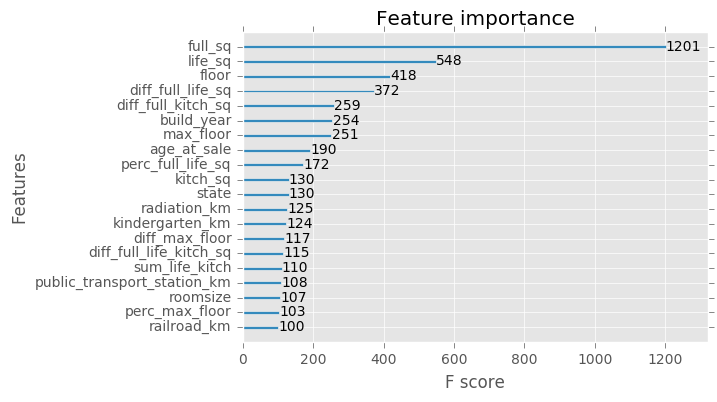

In [28]:
xgb.plot_importance(model, max_num_features=20)
pass

In [29]:
pred = model.predict(dtrain)

In [30]:
error = np.mean(abs(pred - y_train)) / len(y_train)

In [31]:
n = 1 / len(y_train)
rmsle = np.sqrt(1/n * np.sum(np.power(np.log(pred + 1) - np.log(y_train.values + 1), 2)))

/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


In [32]:
print("RMSLE: {rmsle}, Error: {error}".format(rmsle=rmsle, error=error))

RMSLE: nan, Error: 38.878103847606425


In [33]:
dtest = xgb.DMatrix(x_test)

In [34]:
y_predict = model.predict(dtest)

In [35]:
output = pd.DataFrame({"id": x_test.index, "price_doc": y_predict})

In [36]:
output.to_csv("submissions_add_features.csv", index=False)